In [1]:
#--- 1: IMPORTING DATASET ---

import kagglehub
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1.1 Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [2]:
#--- 2: FILE INITILAZION and DATASET OVERVIEW ---

# 2.1 Reading CSV file from dataset.
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

# 2.2 Printing row count and features for data analysis.
print(f"1. Row Count(Unique Student Count): {df.shape[0]}")
print(f"2. Columns (Features): \n{df.columns.tolist()}")

# 2.3 Target analysis.
target_col = 'Depression'
if target_col in df.columns:
    print(f"3. Target Value: {target_col}")
    print(f"Target Distrubiton:\n{df[target_col].value_counts()}")

1. Row Count(Unique Student Count): 27901
2. Columns (Features): 
['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
3. Target Value: Depression
Target Distrubiton:
Depression
1    16336
0    11565
Name: count, dtype: int64


In [3]:
# --- 3. DATA PREPROCESSING ---

# A: Noise Reduction & String Cleaning
# ---------------------------------------------------------
# [CRITICAL FIX]: Clean whitespace and remove extra quotes from string columns
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.replace("'", "").str.strip())

# [CRITICAL FIX]: Handle '?' in Financial Stress and convert to numeric
if 'Financial Stress' in df.columns:
    df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors='coerce')
    df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].mean())

# Filter for 'Student' only
if 'Profession' in df.columns:
    df = df[df['Profession'] == 'Student']
    df = df.drop(columns=['Profession'])

# Drop unnecessary columns
cols_to_drop = ['City', 'Job Satisfaction', 'Work Pressure', 'id']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# [YENİ]: Tekrar eden satırları kaldır (Split öncesi kritik adım)
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Tekrar eden {initial_rows - df.shape[0]} satır silindi.")


# B: Encoding
# ---------------------------------------------------------
# B.1 Ordinal Encoding (Sleep & Diet)
sleep_map = {
    'Less than 5 hours': 1,
    'Others': 2,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}

diet_map = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3,
    'Others': 2
}

df['Sleep Duration'] = df['Sleep Duration'].map(sleep_map).fillna(2)
df['Dietary Habits'] = df['Dietary Habits'].map(diet_map).fillna(2)

# B.2 One-Hot Encoding (Gender & Degree)
categorical_cols = ['Gender', 'Degree']
df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], drop_first=True)

# B.3 Binary Encoding (Yes/No Questions)
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Depression']

for col in binary_cols:
    if col in df.columns:
        # Only map if column is not already numeric
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].map(binary_map)
            df[col] = df[col].fillna(0).astype(int)


# C: Feature Scaling (MinMax 0-1)
# ---------------------------------------------------------
cols_to_scale = ['Age', 'CGPA', 'Academic Pressure', 'Study Satisfaction',
                 'Financial Stress', 'Work/Study Hours', 'Sleep Duration', 'Dietary Habits']

existing_cols_to_scale = [c for c in cols_to_scale if c in df.columns]

scaler = MinMaxScaler()
df[existing_cols_to_scale] = scaler.fit_transform(df[existing_cols_to_scale])


# --- FINAL TAILORED DATASET REPORT ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n=== PREPROCESSING COMPLETE: FINAL DATASET REPORT ===\n")

# Dimensions
print(f"1. Rows:    {df.shape[0]}")
print(f"2. Columns: {df.shape[1]}")

# Missing Values Check
null_count = df.isnull().sum().sum()
print(f"\n3. Total Missing Values: {null_count}")
if null_count > 0:
    print("   ⚠️ WARNING: Missing values found in the following columns:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("   ✅ Success: No missing values found.")

# Data Type Check
print("\n4. Data Type Check:")
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
if len(obj_cols) > 0:
    print(f"   ⚠️ WARNING: Non-numeric columns detected: {obj_cols}")
else:
    print("   ✅ Success: All columns are numeric.")

# Scaling Check
print("\n5. Feature Scaling Check (Min-Max Distribution):")
# Transpose for readability
stats = df.describe().T[['min', 'max', 'mean']]
print(stats)

# Sample Data
print("\n=== SAMPLE DATA (RANDOM 10 ROWS) ===")
print(df.sample(10))


from sklearn.model_selection import train_test_split

# D: Data Splitting (Train / Validation / Test) ---

# Define Target (y) and Features (X)
y = df['Depression']                 # Target variable
X = df.drop(columns=['Depression'])  # Feature matrix

# 1st Split: shuffle=True varsayılandır ama açıkça yazabiliriz
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
    shuffle=True  # <--- Zaten default ama burada görebilirsin
)

# 2nd Split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp,
    shuffle=True # <--- İkinci bölmede de karıştırılır
)
# --- SPLIT REPORT ---
print("\n=== DATA SPLITTING REPORT (3-WAY SPLIT) ===")
print(f"1. Training Set (70%):   {X_train.shape[0]} rows (Used for model training)")
print(f"2. Validation Set (15%): {X_val.shape[0]} rows (Used for tuning/evaluation)")
print(f"3. Test Set (15%):       {X_test.shape[0]} rows (Used for final testing)")

Tekrar eden 0 satır silindi.

=== PREPROCESSING COMPLETE: FINAL DATASET REPORT ===

1. Rows:    27870
2. Columns: 39

3. Total Missing Values: 0
   ✅ Success: No missing values found.

4. Data Type Check:
   ✅ Success: All columns are numeric.

5. Feature Scaling Check (Min-Max Distribution):
                                       min  max      mean
Age                                    0.0  1.0  0.190759
Academic Pressure                      0.0  1.0  0.628123
CGPA                                   0.0  1.0  0.765603
Study Satisfaction                     0.0  1.0  0.588712
Sleep Duration                         0.0  1.0  0.466140
Dietary Habits                         0.0  1.0  0.452099
Have you ever had suicidal thoughts ?  0.0  1.0  0.632616
Work/Study Hours                       0.0  1.0  0.596496
Financial Stress                       0.0  1.0  0.534880
Family History of Mental Illness       0.0  1.0  0.483889
Depression                             0.0  1.0  0.585145

=== SAMPL


=== MODEL ARCHITECTURE ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7631 - loss: 0.4856 - val_accuracy: 0.8383 - val_loss: 0.3721
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8361 - loss: 0.3738 - val_accuracy: 0.8352 - val_loss: 0.3676
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8438 - loss: 0.3606 - val_accuracy: 0.8352 - val_loss: 0.3671
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8459 - loss: 0.3511 - val_accuracy: 0.8361 - val_loss: 0.3653
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8468 - loss: 0.3496 - val_accuracy: 0.8368 - val_loss: 0.3647
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8486 - loss: 0.3559 - val_accuracy: 0.8344 - val_loss: 0.3677
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8433 - loss: 0.3571 - val_accuracy: 0.8337 - val_loss: 0.3661
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8455 - los

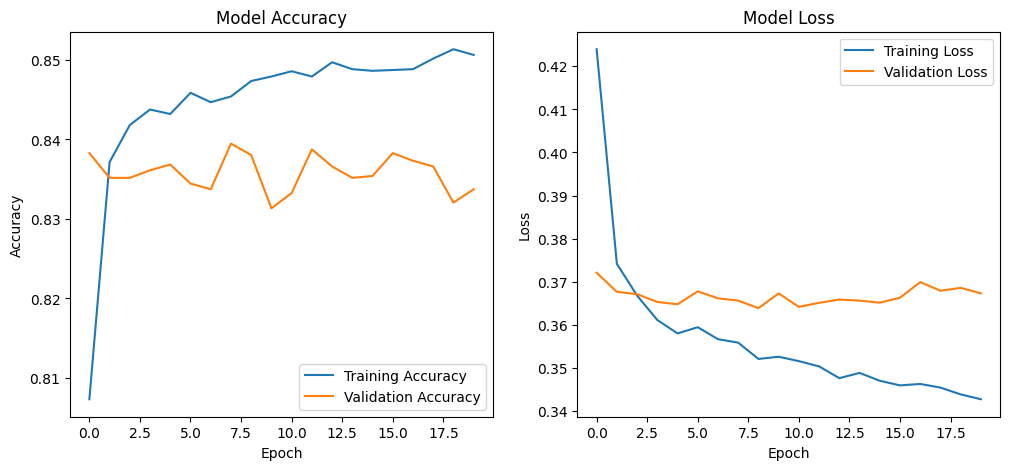

In [7]:

# --- BASELINE MODEL ARCHITECTURE ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt




input_dim = X_train.shape[1]

# 2. Build the Model (Sequential: Stacking layers one by one)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile the Model
# Optimizer: 'adam' (The most popular and efficient optimization algorithm)
# Loss: 'binary_crossentropy' (Standard loss function for Yes/No problems)
# Metrics: 'accuracy' (To monitor performance in percentage)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show Model Summary
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

print("\nStarting Model Training...")

# Train the Model (Fit)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- G: VISUALIZE TRAINING RESULTS ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


=== MODEL ARCHITECTURE ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7139 - loss: 0.5430 - val_accuracy: 0.8306 - val_loss: 0.3808
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8316 - loss: 0.3887 - val_accuracy: 0.8356 - val_loss: 0.3692
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8405 - loss: 0.3765 - val_accuracy: 0.8380 - val_loss: 0.3682
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8410 - loss: 0.3719 - val_accuracy: 0.8383 - val_loss: 0.3671
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8431 - loss: 0.3633 - val_accuracy: 0.8385 - val_loss: 0.3654
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8436 - loss: 0.3631 - val_accuracy: 0.8402 - val_loss: 0.3649
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8432 - loss: 0.3653 - val_accuracy: 0.8388 - val_loss: 0.3633
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8433 - los

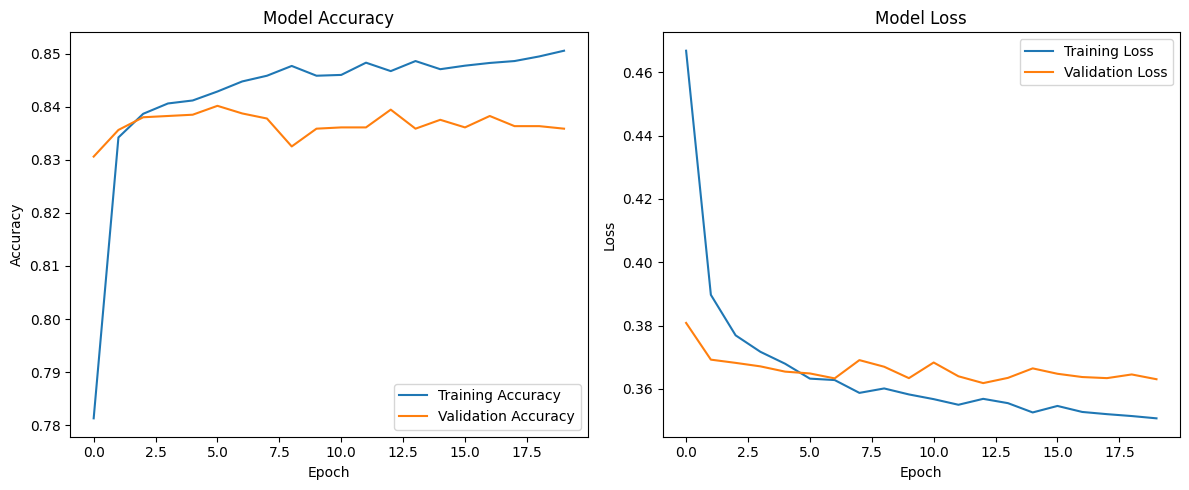

In [8]:
# --- EXPERIMENT 1 ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt



# 1. Giriş Boyutunu Al
input_dim = X_train.shape[1]

# 2. Modeli İnşa Et (Sequential)
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2)) # %20 nöronu kapatarak ezberi önler
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. Modeli Derle (Compile)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Özetini Göster
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

print("\nStarting Model Training...")

# 4. Modeli Eğit (Fit)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,       # 20 Epoch genellikle baseline için yeterlidir
    batch_size=32,
    verbose=1
)




test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]


print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

[I 2025-12-12 20:10:53,767] A new study created in memory with name: no-name-ea2fa684-cd76-4659-9754-9c44cc340f65


Optuna en iyi hiperparametreleri arıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-12 20:11:30,697] Trial 0 finished with value: 0.8375598192214966 and parameters: {'n_units': 116, 'dropout_rate': 0.18944969002783166, 'lr': 0.000160386148761214, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.8375598192214966.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-12 20:11:49,203] Trial 1 finished with value: 0.8366028666496277 


>>> EN İYİ SONUÇLAR:
Best hyperparameters: {'n_units': 116, 'dropout_rate': 0.18944969002783166, 'lr': 0.000160386148761214, 'optimizer': 'adam', 'batch_size': 16}
Best validation accuracy: 0.8375598192214966

=== FINAL MODEL TRAINING (With Best Params) ===
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7103 - loss: 0.5533 - val_accuracy: 0.8280 - val_loss: 0.3812
Epoch 2/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8365 - loss: 0.3790 - val_accuracy: 0.8361 - val_loss: 0.3705
Epoch 3/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8394 - loss: 0.3707 - val_accuracy: 0.8373 - val_loss: 0.3683
Epoch 4/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8432 - loss: 0.3640 - val_accuracy: 0.8361 - val_loss: 0.3667
Epoch 5/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8403 - loss: 0.3657 - val_accuracy: 0.8366 - val_loss: 0.3709
Epoch 6/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8424 - loss: 0.3630 - val_accuracy: 0.8378 - val_loss: 0.3668
Epoch 7/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8444 - loss: 0.3615 - val_accuracy: 0.8364 - val_loss: 0.3681
Epoch 8/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8471 - loss: 0.3535 - val_accurac

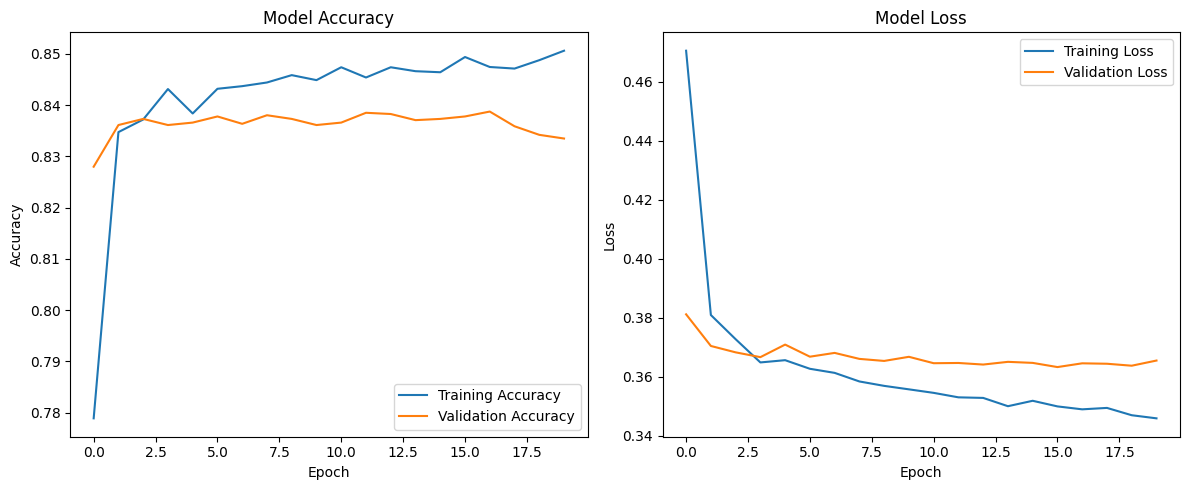

In [12]:
# --- EXPERIMENT 2 ---
!pip install optuna
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# --- 1. MODEL OLUŞTURUCU FONKSİYON (Senin Şablonun) ---
def create_model(trial):
    # Arama Uzayı (Search Space)
    # Nöron sayısını verisetimiz küçük olduğu için 16-128 arasında tuttum
    n_units = trial.suggest_int("n_units", 16, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # Optimizer Seçimi (İstediğin gibi Categorical)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Optimizer Nesnesini Oluştur
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    # Model Mimarisi (Experiment 1 mantığına uygun: Büyük -> Küçük)
    model = Sequential([
        Dense(n_units, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(n_units // 2, activation="relu"), # İkinci katman ilkinin yarısı kadar olsun
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid") # Binary Classification
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model, batch_size

# --- 2. OBJECTIVE FUNCTION ---
def objective(trial):
    # Modeli ve batch_size'ı al
    model, batch_size = create_model(trial)

    # Hızlı eğitim (Optuna arama yaparken uzun sürmesin diye epoch az tutulur)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val), # Validation setini kullanıyoruz
        epochs=10,
        batch_size=batch_size,
        verbose=0 # Ekrana basma, sessizce dene
    )

    # Son epoch'taki validation accuracy'yi döndür
    val_acc = history.history["val_accuracy"][-1]
    return val_acc

# --- 3. OPTIMIZATION (ARAMA BAŞLIYOR) ---
print("Optuna en iyi hiperparametreleri arıyor...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4) # 4 farklı kombinasyon deneyecek

print("\n>>> EN İYİ SONUÇLAR:")
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)


# --- 4. FİNAL MODELİ EĞİTME (En İyilerle) ---
print("\n=== FINAL MODEL TRAINING (With Best Params) ===")

# En iyi parametreleri alıp modeli tekrar (temizce) kuruyoruz
best_params = study.best_params

# Best params içinden değerleri çekip manuel tanımlıyoruz (Veya create_model'i parametreli yapabilirdik)
# Ancak senin yapını bozmamak için manuel kuruyorum:
final_model = Sequential([
    Dense(best_params["n_units"], activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_units"] // 2, activation="relu"),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation="sigmoid")
])

# Optimizer'ı en iyi seçime göre ayarla
if best_params["optimizer"] == "adam":
    opt = Adam(learning_rate=best_params["lr"])
elif best_params["optimizer"] == "sgd":
    opt = SGD(learning_rate=best_params["lr"])
else:
    opt = RMSprop(learning_rate=best_params["lr"])

final_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Asıl Eğitim (20 Epoch - Senin Standardın)
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=best_params["batch_size"],
    verbose=1
)

# --- 5. RAPORLAMA VE GRAFİKLER ---

test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


=== MODEL ARCHITECTURE ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 8)              │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6478 - loss: 0.5943 - val_accuracy: 0.8321 - val_loss: 0.4077
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8419 - loss: 0.3836 - val_accuracy: 0.8388 - val_loss: 0.3733
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8415 - loss: 0.3644 - val_accuracy: 0.8373 - val_loss: 0.3673
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8416 - loss: 0.3622 - val_accuracy: 0.8368 - val_loss: 0.3651
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8509 - loss: 0.3495 - val_accuracy: 0.8368 - val_loss: 0.3641
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8467 - loss: 0.3498 - val_accuracy: 0.8356 - val_loss: 0.3634
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8473 - loss: 0.3529 - val_accuracy: 0.8366 - val_loss: 0.3637
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8415 - los

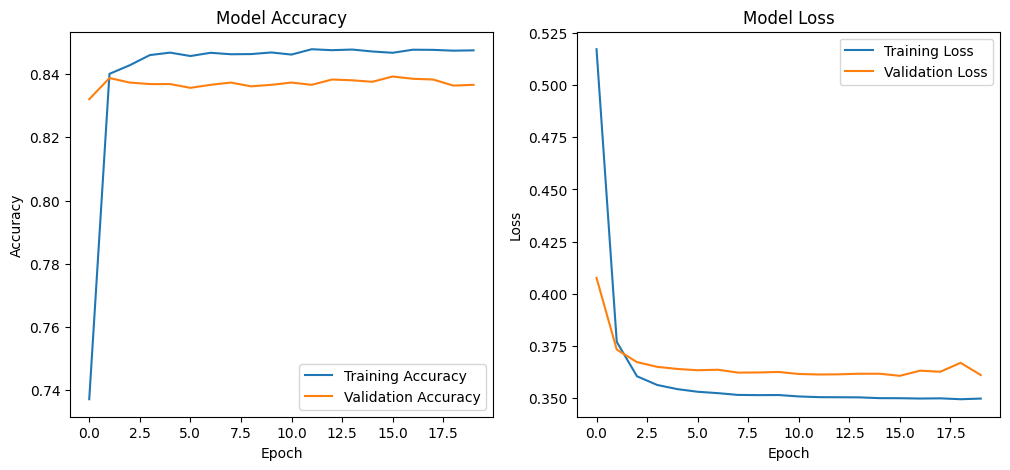

In [13]:

# --- EXPERIMENT 3 ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt




input_dim = X_train.shape[1]

# 2. Build the Model (Sequential: Stacking layers one by one)
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=input_dim))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile the Model
# Optimizer: 'adam' (The most popular and efficient optimization algorithm)
# Loss: 'binary_crossentropy' (Standard loss function for Yes/No problems)
# Metrics: 'accuracy' (To monitor performance in percentage)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show Model Summary
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

print("\nStarting Model Training...")

# Train the Model (Fit)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- G: VISUALIZE TRAINING RESULTS ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


=== MODEL ARCHITECTURE ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 8)              │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6699 - loss: 0.6009 - val_accuracy: 0.8318 - val_loss: 0.4050
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8370 - loss: 0.3844 - val_accuracy: 0.8373 - val_loss: 0.3719
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8463 - loss: 0.3577 - val_accuracy: 0.8373 - val_loss: 0.3671
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8503 - loss: 0.3470 - val_accuracy: 0.8378 - val_loss: 0.3643
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8485 - loss: 0.3506 - val_accuracy: 0.8342 - val_loss: 0.3648
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8479 - loss: 0.3513 - val_accuracy: 0.8373 - val_loss: 0.3623
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8477 - loss: 0.3517 - val_accuracy: 0.8349 - val_loss: 0.3622
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8460 - los

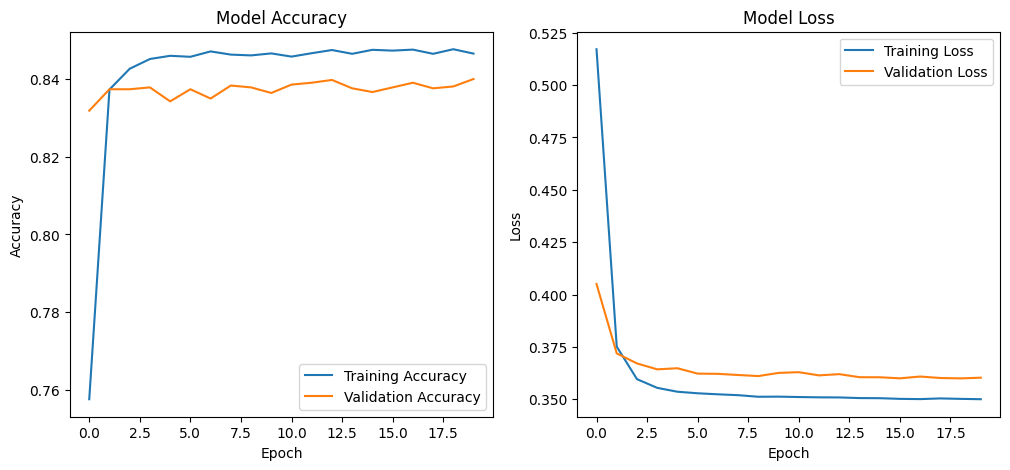

In [14]:

# --- EXPERIMENT 4 ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt




input_dim = X_train.shape[1]

# 2. Build the Model (Sequential: Stacking layers one by one)
model = Sequential()
model.add(Dense(8, activation='tanh', input_dim=input_dim))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile the Model
# Optimizer: 'adam' (The most popular and efficient optimization algorithm)
# Loss: 'binary_crossentropy' (Standard loss function for Yes/No problems)
# Metrics: 'accuracy' (To monitor performance in percentage)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show Model Summary
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

print("\nStarting Model Training...")

# Train the Model (Fit)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- G: VISUALIZE TRAINING RESULTS ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


=== MODEL ARCHITECTURE ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 8)              │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6503 - loss: 0.5986 - val_accuracy: 0.7854 - val_loss: 0.5134
Epoch 2/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7992 - loss: 0.4877 - val_accuracy: 0.8124 - val_loss: 0.4491
Epoch 3/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8147 - loss: 0.4370 - val_accuracy: 0.8249 - val_loss: 0.4152
Epoch 4/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8237 - loss: 0.4049 - val_accuracy: 0.8304 - val_loss: 0.3961
Epoch 5/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8318 - loss: 0.3851 - val_accuracy: 0.8364 - val_loss: 0.3849
Epoch 6/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8344 - loss: 0.3769 - val_accuracy: 0.8371 - val_loss: 0.3784
Epoch 7/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8389 - loss: 0.3680 - val_accuracy: 0.8395 - val_loss: 0.3739
Epoch 8/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8378 - los

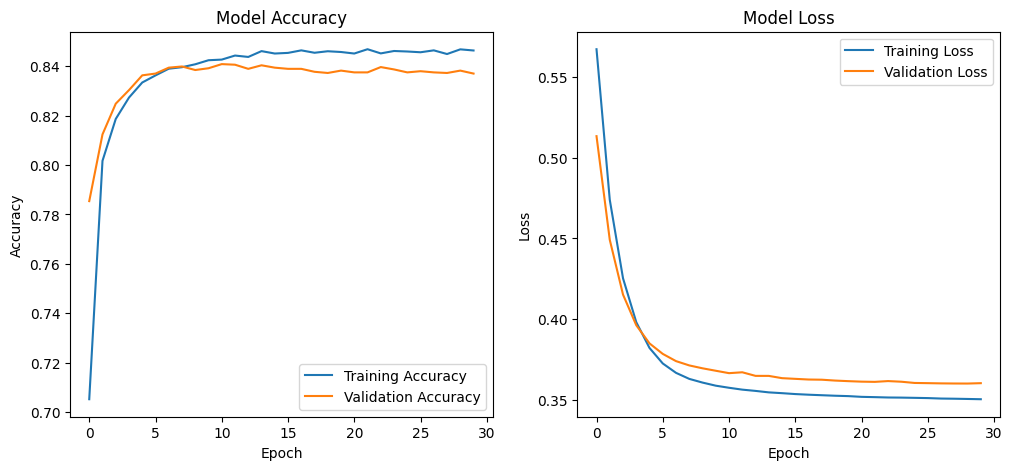

In [18]:

# --- EXPERIMENT 5 ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt




input_dim = X_train.shape[1]

# 2. Build the Model (Sequential: Stacking layers one by one)
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=input_dim))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile the Model
# Optimizer: 'adam' (The most popular and efficient optimization algorithm)
# Loss: 'binary_crossentropy' (Standard loss function for Yes/No problems)
# Metrics: 'accuracy' (To monitor performance in percentage)

opt = SGD(learning_rate=0.015, momentum=0.5)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show Model Summary
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

print("\nStarting Model Training...")

# Train the Model (Fit)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    verbose=1
)

# --- G: VISUALIZE TRAINING RESULTS ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
print("\n=== FINAL RESULTS ===")
print("-" * 40)
print(f"Test Set Loss:           {test_loss:.4f}")
print(f"Test Set Accuracy:       {test_acc:.4f}")
print("-" * 40)
print(f"Validation Loss:         {val_loss:.4f}")
print(f"Validation Accuracy:     {val_acc:.4f}")
print("-" * 40)

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()